In [43]:
"""
# Normalizing Flows Implementation Guide

## Introduction
Normalizing flows are a class of generative models that learn complex probability distributions 
by transforming a simple base distribution through a sequence of invertible mappings.

## Key Concepts

### 1. Change of Variables Formula
The fundamental principle behind normalizing flows is the change of variables formula:
p_x(x) = p_z(z) * |det(dz/dx)|
where:
- p_x(x) is the target distribution
- p_z(z) is the base distribution (usually standard normal)
- |det(dz/dx)| is the absolute determinant of the Jacobian

### 2. Flow Types
Different flow architectures provide different ways to transform the data while maintaining
invertibility and tractable Jacobian determinants:
- Planar: Uses planar transformations (f(z) = z + u*h(w^T*z + b))
- Radial: Uses radial transformations around a learned reference point
- RealNVP: Uses affine coupling layers with masked transformations
- MAF: Uses autoregressive transformations for increased flexibility
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import Normal


In [44]:
def create_toy_dataset(n_samples=1000, dataset_type='two_gaussians'):
    """
    Creates various 2D toy datasets
    """
    if dataset_type == 'two_gaussians':
        z = np.random.randn(n_samples, 2) * 0.5
        z[:n_samples//2, 0] += 2
        z[n_samples//2:, 0] -= 2
    elif dataset_type == 'circles':
        r = np.random.normal(1, 0.1, n_samples)
        theta = np.random.uniform(0, 2*np.pi, n_samples)
        z = np.stack([r*np.cos(theta), r*np.sin(theta)], axis=1)
    elif dataset_type == 'moons':
        t = np.random.uniform(0, np.pi, n_samples)
        x = np.cos(t)
        y = np.sin(t)
        z1 = np.stack([x, y], axis=1)
        z2 = np.stack([x+1, y-1], axis=1)
        z = np.vstack([z1[:n_samples//2], z2[n_samples//2:]])
        z += np.random.normal(0, 0.1, z.shape)
    
    return torch.FloatTensor(z)

In [45]:
class PlanarFlow(nn.Module):
    """
    Planar flow with fixed log determinant shape
    """
    def __init__(self, dim):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, dim))
        self.u = nn.Parameter(torch.randn(1, dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        return z + self.u * activation
    
    def log_det_jacobian(self, z):
        activation = torch.tanh(F.linear(z, self.w, self.b))
        psi = (1 - activation**2) * self.w
        det = 1 + torch.matmul(psi, self.u.T)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RadialFlow(nn.Module):
    """
    Radial flow: f(z) = z + β h(α,r)(z-z_0)
    where r is the distance from z_0 and h(α,r) = 1/(α + r)
    """
    def __init__(self, dim):
        super().__init__()
        self.z0 = nn.Parameter(torch.randn(1, dim))
        self.log_alpha = nn.Parameter(torch.randn(1))
        self.beta = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        return z + self.beta * h * (z - self.z0)
    
    def log_det_jacobian(self, z):
        alpha = torch.exp(self.log_alpha)
        r = torch.norm(z - self.z0, dim=1, keepdim=True)
        h = 1 / (alpha + r)
        h_prime = -1 / (alpha + r)**2
        det = (1 + self.beta * h + self.beta * h_prime * r)**(z.shape[1] - 1)
        det *= (1 + self.beta * h)
        # Ensure output shape is [batch_size]
        return torch.log(torch.abs(det)).squeeze(-1)

class RealNVPCoupling(nn.Module):
    """
    Real NVP coupling layer
    Reference: https://arxiv.org/abs/1605.08803
    """
    def __init__(self, dim, hidden_dim=64, mask_type='alternate'):
        super().__init__()
        self.dim = dim
        
        # Create mask
        self.mask = torch.ones(dim)
        if mask_type == 'alternate':
            self.mask[::2] = 0
        elif mask_type == 'half':
            self.mask[:dim//2] = 0
            
        # Scale and translation networks
        self.s_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim),
            nn.Tanh()
        )
        
        self.t_network = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, dim)
        )
        
    def forward(self, z):
        masked_z = z * self.mask
        s = self.s_network(masked_z) * (1 - self.mask)
        t = self.t_network(masked_z) * (1 - self.mask)
        
        # Scale and shift
        exp_s = torch.exp(s)
        transformed = z * self.mask + (1 - self.mask) * (z * exp_s + t)
        log_det = torch.sum(s * (1 - self.mask), dim=1)
        
        return transformed, log_det

class MAF(nn.Module):
    """
    Masked Autoregressive Flow
    Reference: https://arxiv.org/abs/1705.07057
    """
    def __init__(self, dim, hidden_dim=64):
        super().__init__()
        self.dim = dim
        
        # Create MADE-like network
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2 * dim)  # Output both μ and log_σ
        )
        
        # Create autoregressive mask
        self.register_buffer('mask', self._create_mask())
        
    def _create_mask(self):
        # Create a lower triangular mask
        mask = torch.tril(torch.ones(self.dim, self.dim), -1)
        return mask
    
    def forward(self, z):
        batch_size = z.size(0)
        
        # Get parameters from network
        net_out = self.net(z)
        mu, log_sigma = net_out.chunk(2, dim=1)
        
        # Reshape mask for broadcasting
        mask = self.mask.unsqueeze(0)  # [1, dim, dim]
        
        # Apply mask to ensure autoregressive property
        # Compute masked mu: [batch_size, dim]
        masked_mu = torch.bmm(mask.expand(batch_size, -1, -1), 
                            z.unsqueeze(2)).squeeze(2)
        
        # Transform
        sigma = torch.exp(log_sigma)
        transformed = (z - masked_mu) / sigma
        log_det = -torch.sum(log_sigma, dim=1)
        
        return transformed, log_det


In [46]:
class NormalizingFlow(nn.Module):
    """
    A sequence of normalizing flows with proper log determinant handling
    """
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        
    def forward(self, z):
        log_det_sum = torch.zeros(z.size(0), device=z.device)
        
        for flow in self.flows:
            if isinstance(flow, (RealNVPCoupling, MAF)):
                z, log_det = flow(z)
            else:
                log_det = flow.log_det_jacobian(z)
                z = flow(z)
                
            # Ensure log_det has correct shape [batch_size]
            if log_det.dim() > 1:
                log_det = log_det.sum(1)
            elif log_det.dim() == 0:
                log_det = log_det.expand(z.size(0))
                
            log_det_sum += log_det
            
        return z, log_det_sum



In [47]:

def train_flow(flow, data, n_epochs=1000, lr=1e-4):
    """
    Train the normalizing flow with improved stability
    """
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    losses = []
    
    for epoch in range(n_epochs):
        optimizer.zero_grad()
        
        try:
            # Forward pass through flow
            z, log_det = flow(data)
            
            # Compute loss (negative log likelihood)
            prior_ll = -0.5 * (z**2).sum(1) - 0.5 * np.log(2*np.pi) * z.shape[1]
            loss = -(prior_ll + log_det).mean()
            
            # Check for invalid values
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Warning: Invalid loss value at epoch {epoch+1}")
                continue
                
            # Backward pass
            loss.backward()
            
            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
            
            optimizer.step()
            losses.append(loss.item())
            
            if (epoch + 1) % 100 == 0:
                print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}')
                
        except RuntimeError as e:
            print(f"Error at epoch {epoch+1}: {str(e)}")
            continue
    
    return flow, losses


In [48]:
def visualize_flow(flow, data, n_samples=1000):
    """
    Create comprehensive visualizations of the flow
    """
    with torch.no_grad():
        # Generate samples
        z = torch.randn(n_samples, 2)
        samples, _ = flow(z)
        samples = samples.numpy()
        z = z.numpy()
        data = data.numpy()
    
    fig = plt.figure(figsize=(15, 10))
    
    # Original distribution
    plt.subplot(231)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10, c='blue')
    # Use numpy histogram2d for density estimation
    h, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=50, density=True)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Original Distribution')
    
    # Base distribution
    plt.subplot(232)
    plt.scatter(z[:, 0], z[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = np.histogram2d(z[:, 0], z[:, 1], bins=50, density=True)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Base Distribution (Normal)')
    
    # Generated distribution
    plt.subplot(233)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, c='blue')
    h, xedges, yedges = np.histogram2d(samples[:, 0], samples[:, 1], bins=50, density=True)
    xcenters = (xedges[:-1] + xedges[1:]) / 2
    ycenters = (yedges[:-1] + yedges[1:]) / 2
    X, Y = np.meshgrid(xcenters, ycenters)
    plt.contour(X, Y, h.T, levels=10, cmap='viridis', alpha=0.5)
    plt.title('Generated Distribution')
    
    # Histograms
    plt.subplot(234)
    plt.hist2d(data[:, 0], data[:, 1], bins=50, cmap='viridis', density=True)
    plt.colorbar()
    plt.title('Original Distribution (2D Histogram)')
    
    plt.subplot(235)
    plt.hist2d(z[:, 0], z[:, 1], bins=50, cmap='viridis', density=True)
    plt.colorbar()
    plt.title('Base Distribution (2D Histogram)')
    
    plt.subplot(236)
    plt.hist2d(samples[:, 0], samples[:, 1], bins=50, cmap='viridis', density=True)
    plt.colorbar()
    plt.title('Generated Distribution (2D Histogram)')
    
    plt.tight_layout()
    return fig


Training on two_gaussians dataset:

Training Simple architecture...
Epoch 100/1000, Loss: 2.8844
Epoch 200/1000, Loss: 2.8564
Epoch 300/1000, Loss: 2.8297
Epoch 400/1000, Loss: 2.8042
Epoch 500/1000, Loss: 2.7798
Epoch 600/1000, Loss: 2.7566
Epoch 700/1000, Loss: 2.7343
Epoch 800/1000, Loss: 2.7131
Epoch 900/1000, Loss: 2.6927
Epoch 1000/1000, Loss: 2.6732


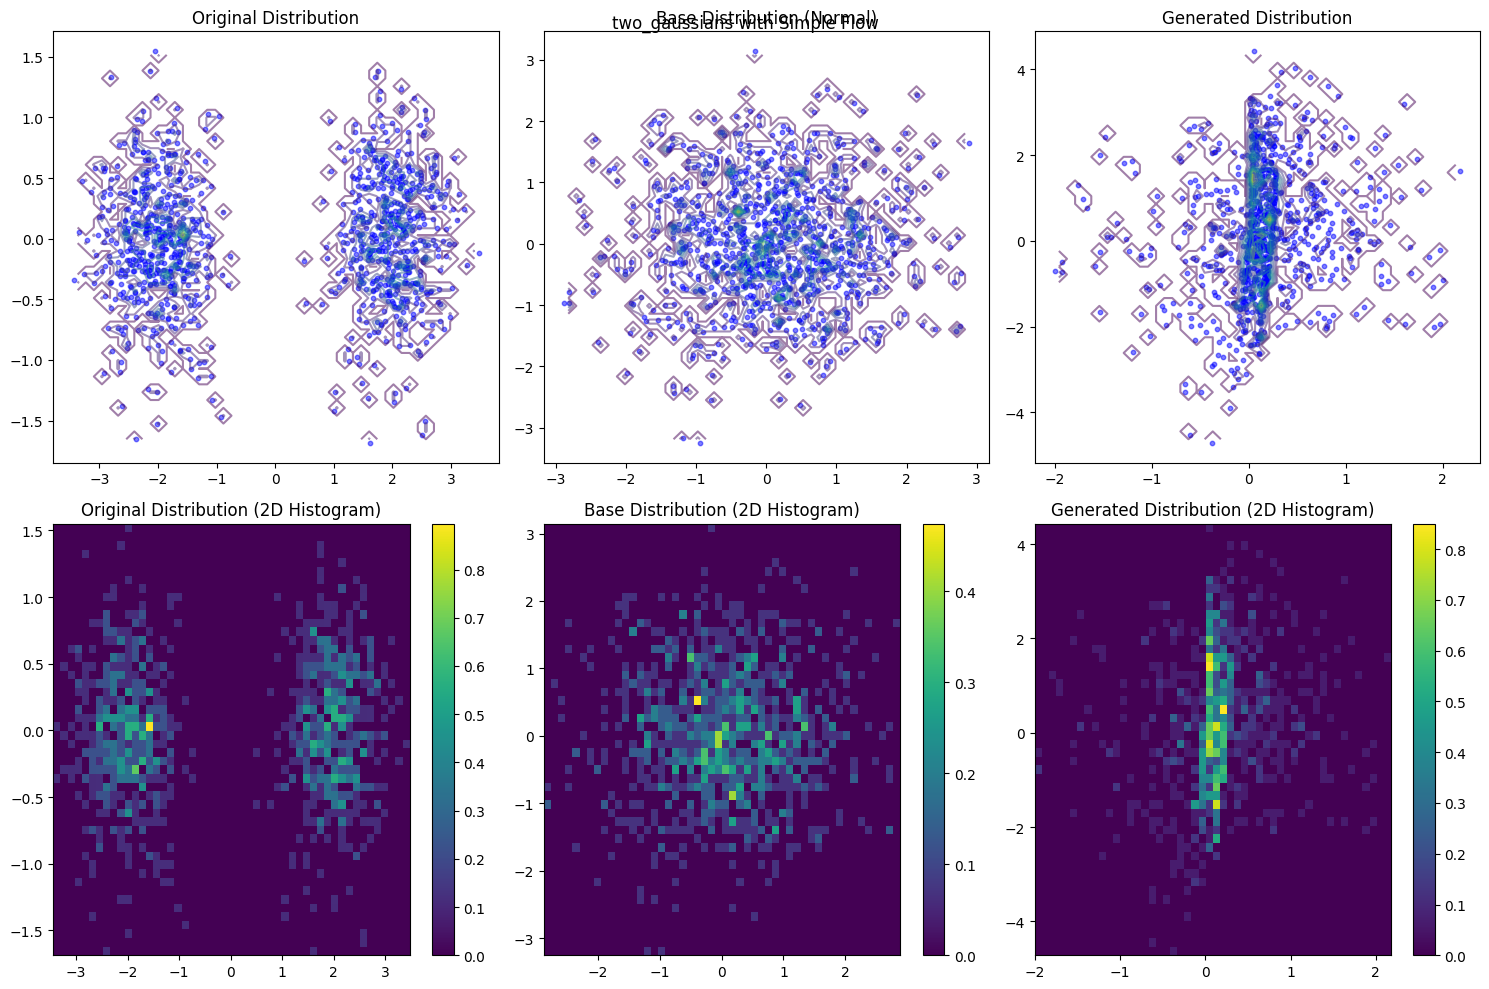

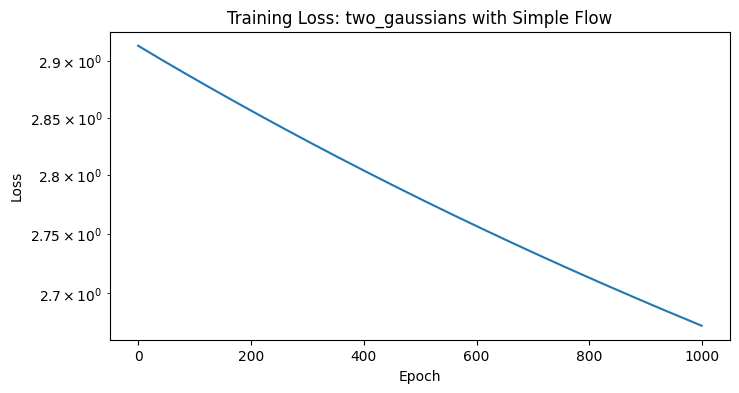


Training RealNVP architecture...
Epoch 100/1000, Loss: 3.1944
Epoch 200/1000, Loss: 3.1819
Epoch 300/1000, Loss: 3.1803
Epoch 400/1000, Loss: 3.1792
Epoch 500/1000, Loss: 3.1782
Epoch 600/1000, Loss: 3.1774
Epoch 700/1000, Loss: 3.1767
Epoch 800/1000, Loss: 3.1761
Epoch 900/1000, Loss: 3.1755
Epoch 1000/1000, Loss: 3.1750


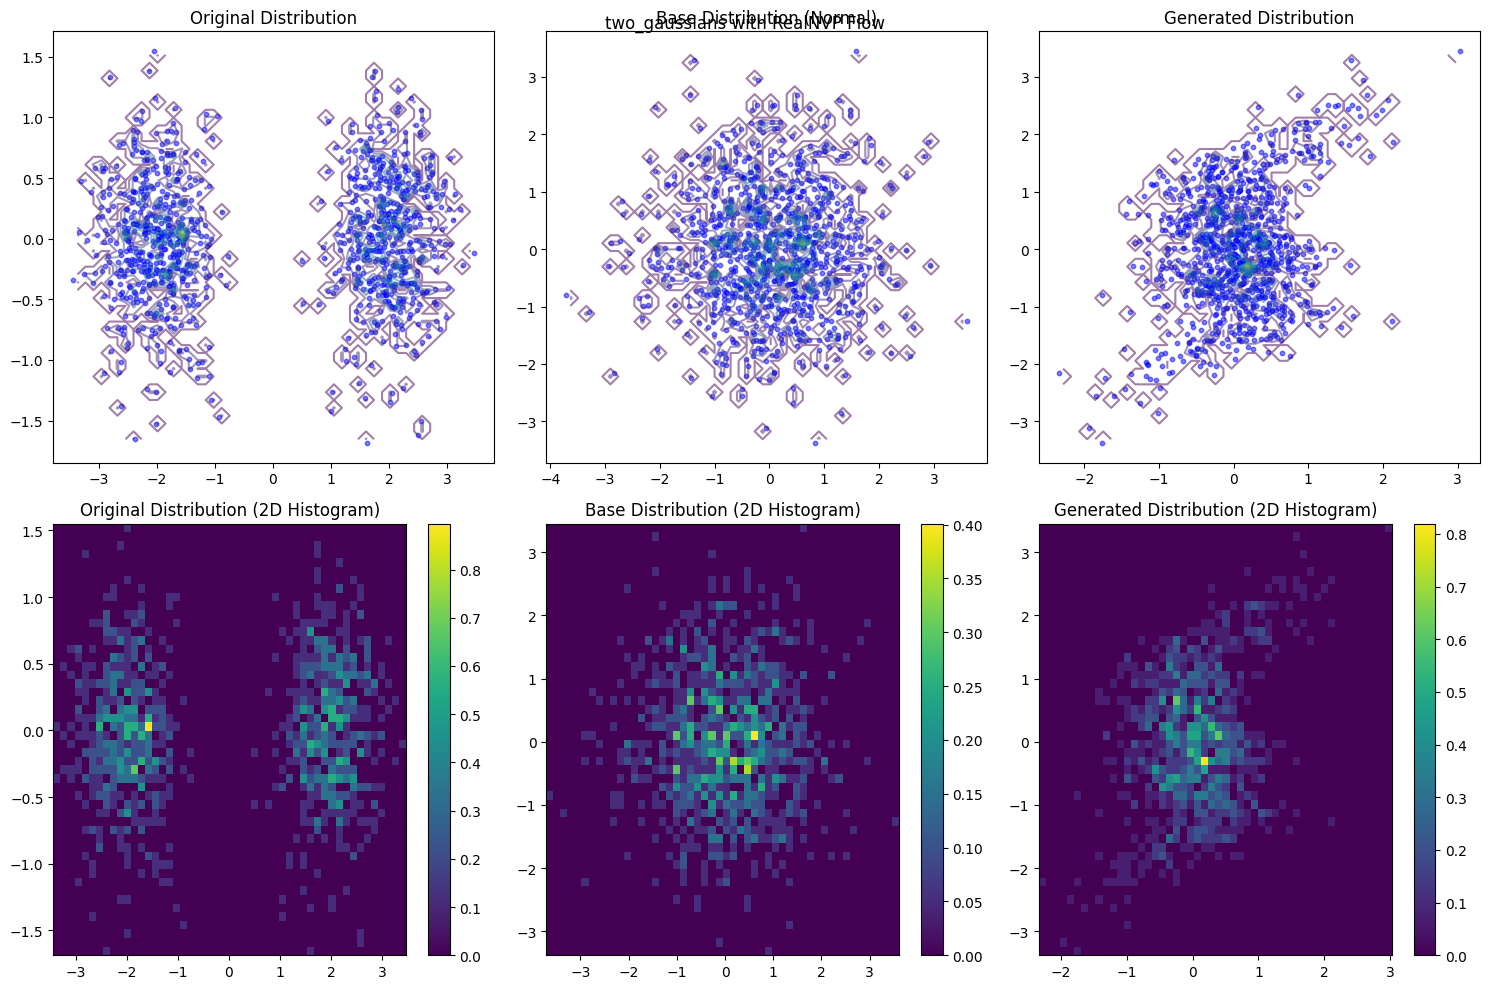

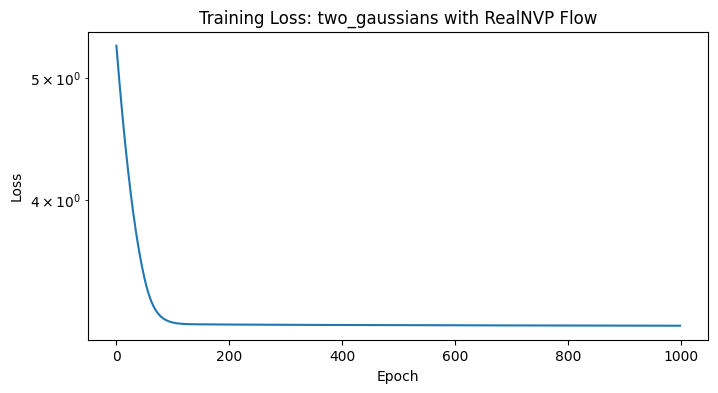


Training MAF architecture...
Epoch 100/1000, Loss: 4.8120
Epoch 200/1000, Loss: 4.4141
Epoch 300/1000, Loss: 4.2920
Epoch 400/1000, Loss: 4.2336
Epoch 500/1000, Loss: 4.1965
Epoch 600/1000, Loss: 4.1728
Epoch 700/1000, Loss: 4.1565
Epoch 800/1000, Loss: 4.1446
Epoch 900/1000, Loss: 4.1364
Epoch 1000/1000, Loss: 4.1306


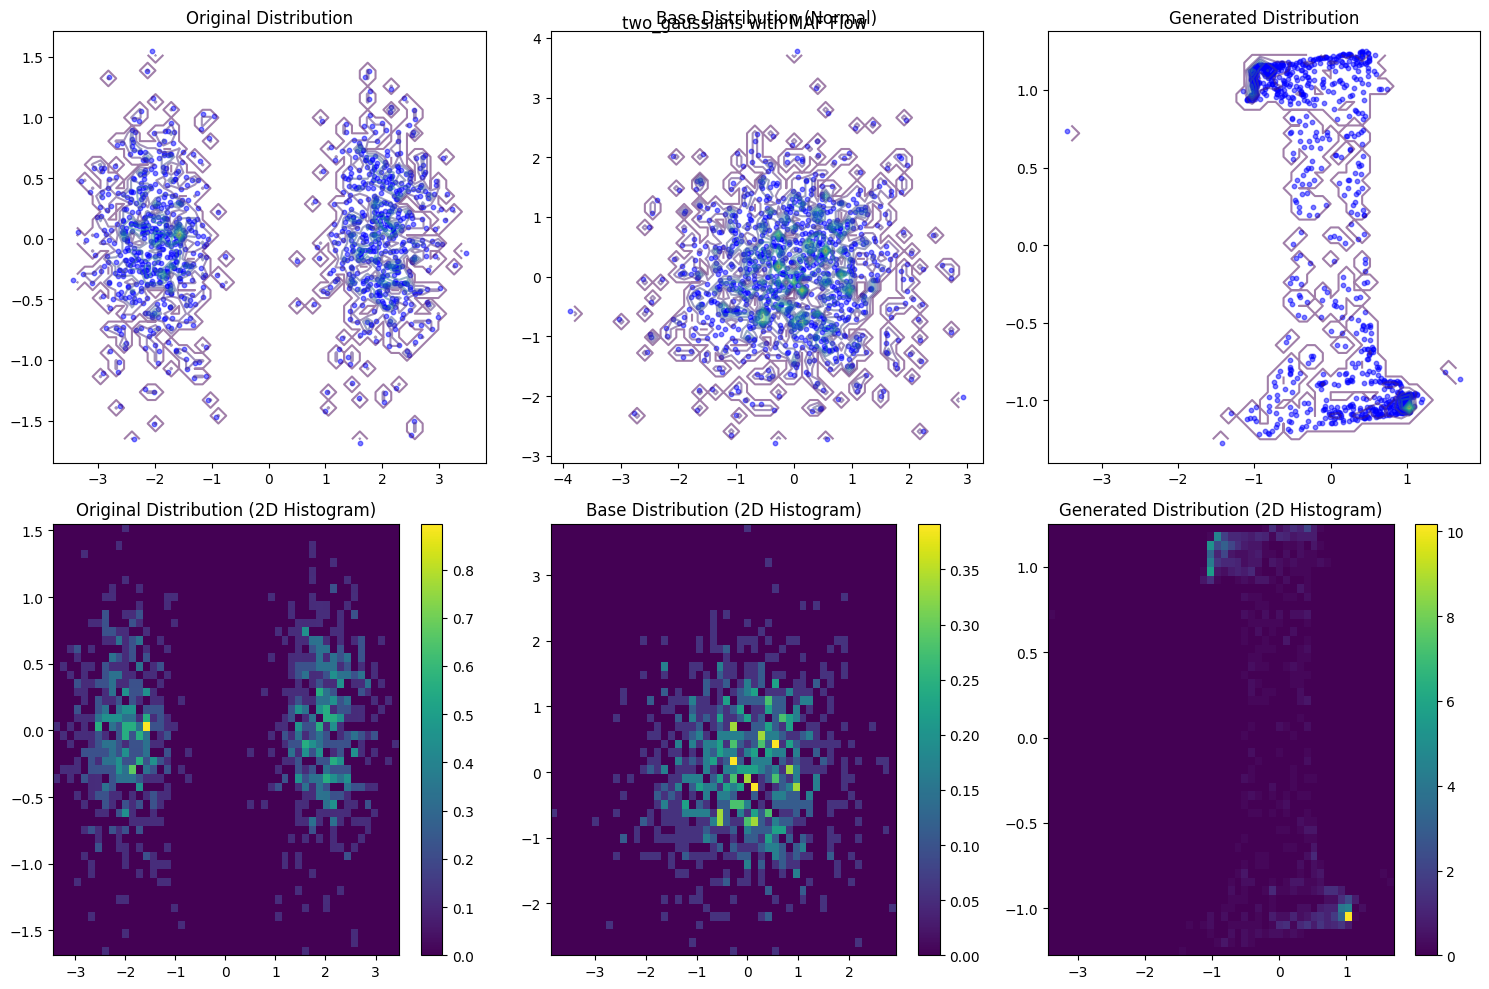

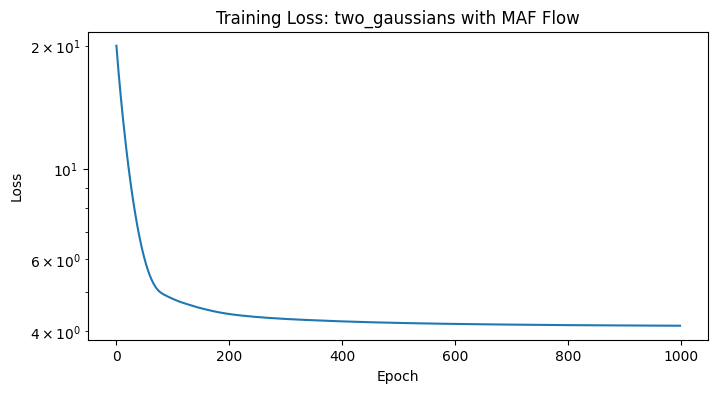


Training Mixed architecture...
Epoch 100/1000, Loss: 3.3819
Epoch 200/1000, Loss: 3.0008
Epoch 300/1000, Loss: 2.7102
Epoch 400/1000, Loss: 2.4376
Epoch 500/1000, Loss: 2.1749
Epoch 600/1000, Loss: 1.9206
Epoch 700/1000, Loss: 1.7447
Epoch 800/1000, Loss: 1.6357
Epoch 900/1000, Loss: 1.5590
Epoch 1000/1000, Loss: 1.4950


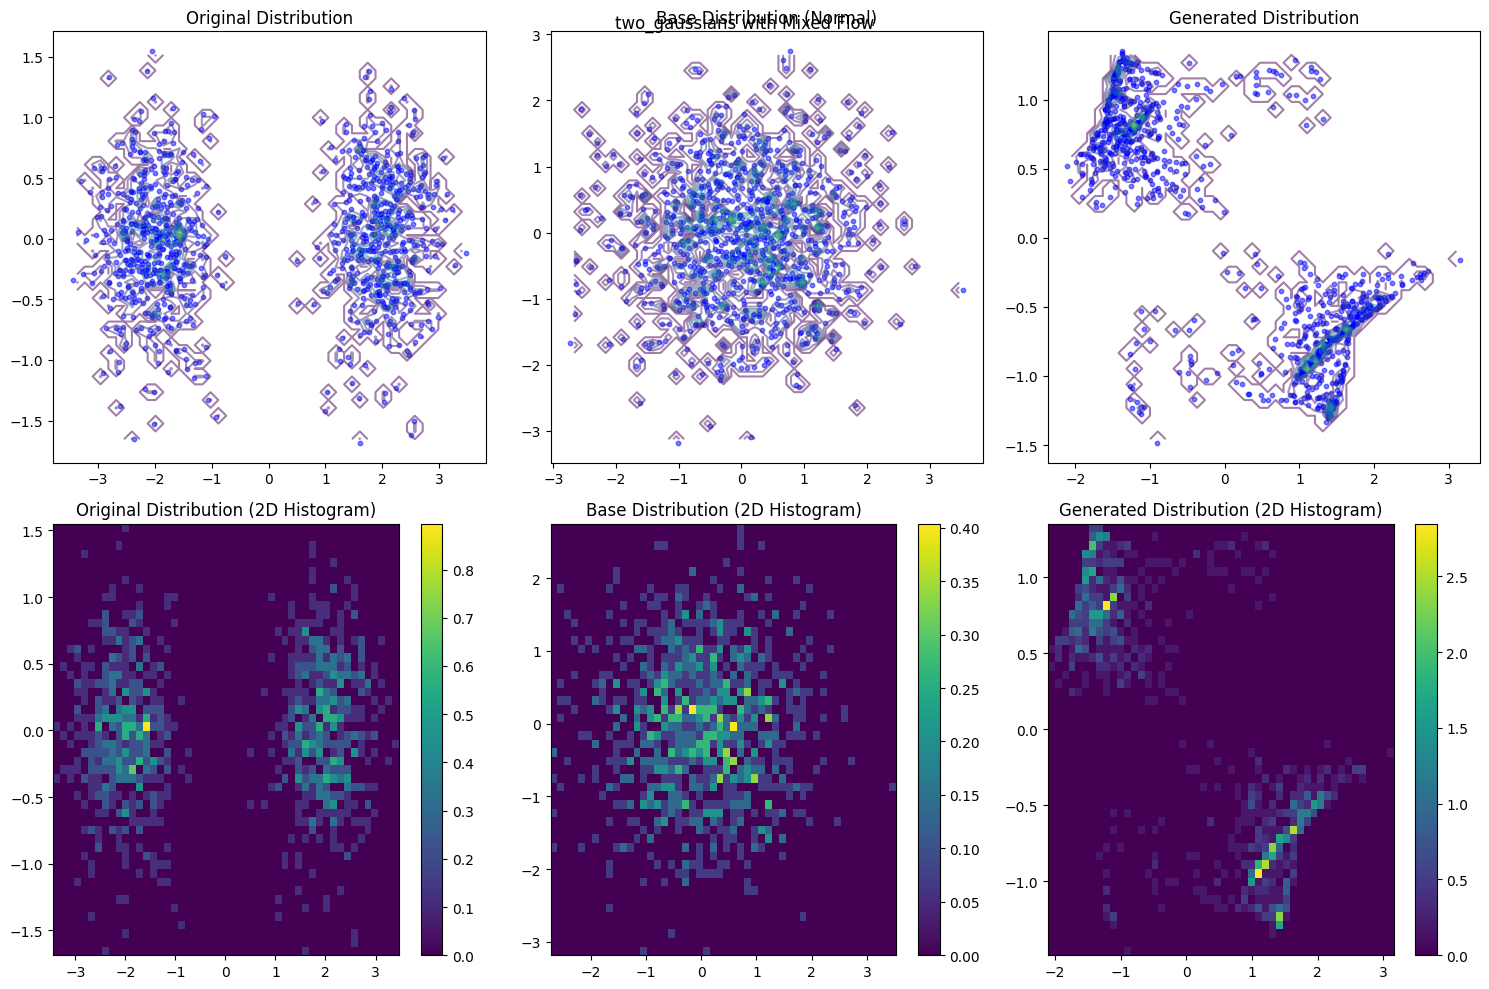

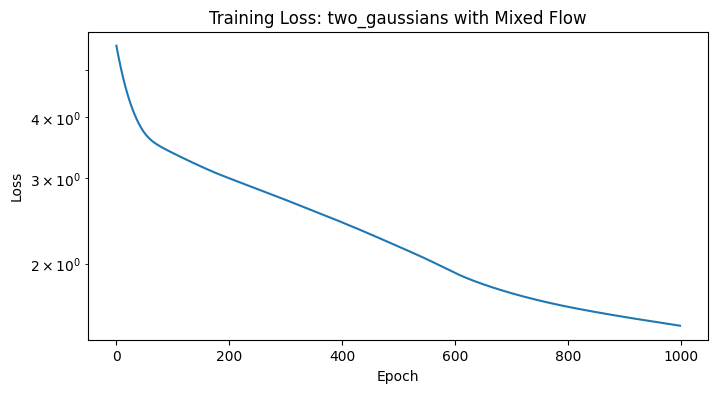


Training on circles dataset:

Training Simple architecture...
Epoch 100/1000, Loss: 2.8362
Epoch 200/1000, Loss: 2.8131
Epoch 300/1000, Loss: 2.7905
Epoch 400/1000, Loss: 2.7684
Epoch 500/1000, Loss: 2.7467
Epoch 600/1000, Loss: 2.7256
Epoch 700/1000, Loss: 2.7048
Epoch 800/1000, Loss: 2.6846
Epoch 900/1000, Loss: 2.6647
Epoch 1000/1000, Loss: 2.6452


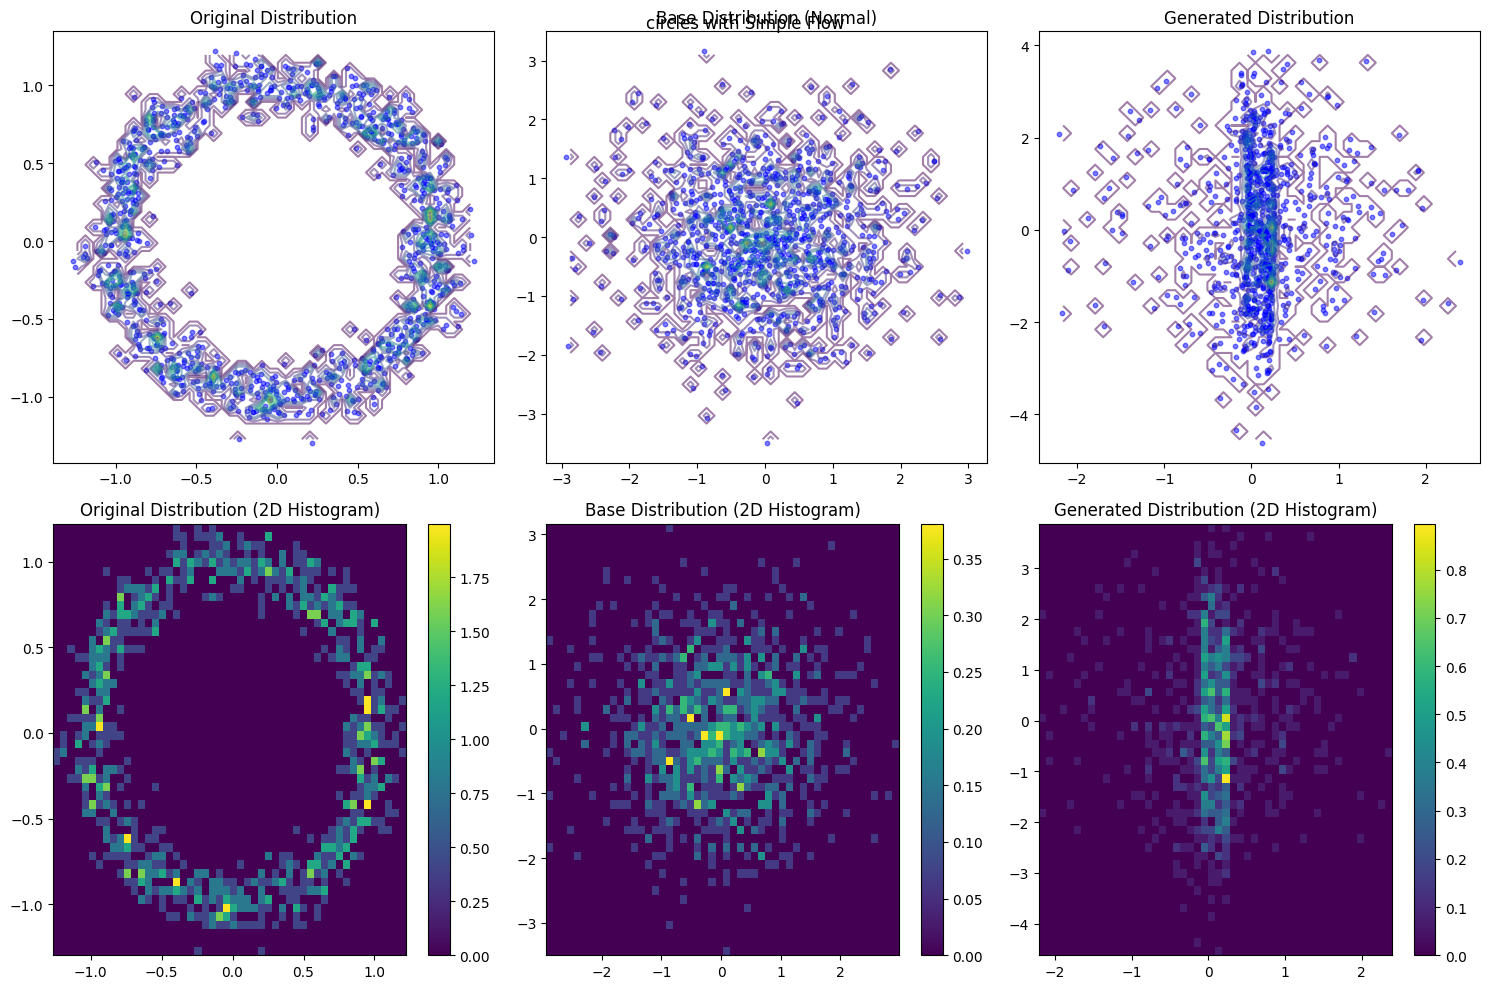

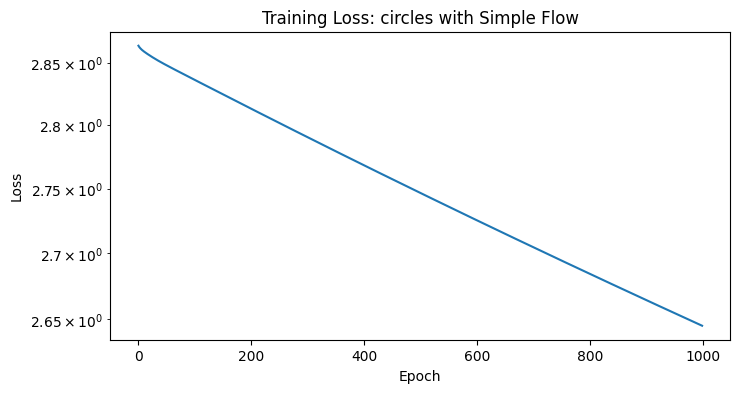


Training RealNVP architecture...
Epoch 100/1000, Loss: 2.2013
Epoch 200/1000, Loss: 2.1546
Epoch 300/1000, Loss: 2.1242
Epoch 400/1000, Loss: 2.1066
Epoch 500/1000, Loss: 2.0979
Epoch 600/1000, Loss: 2.0937
Epoch 700/1000, Loss: 2.0915
Epoch 800/1000, Loss: 2.0900
Epoch 900/1000, Loss: 2.0889
Epoch 1000/1000, Loss: 2.0881


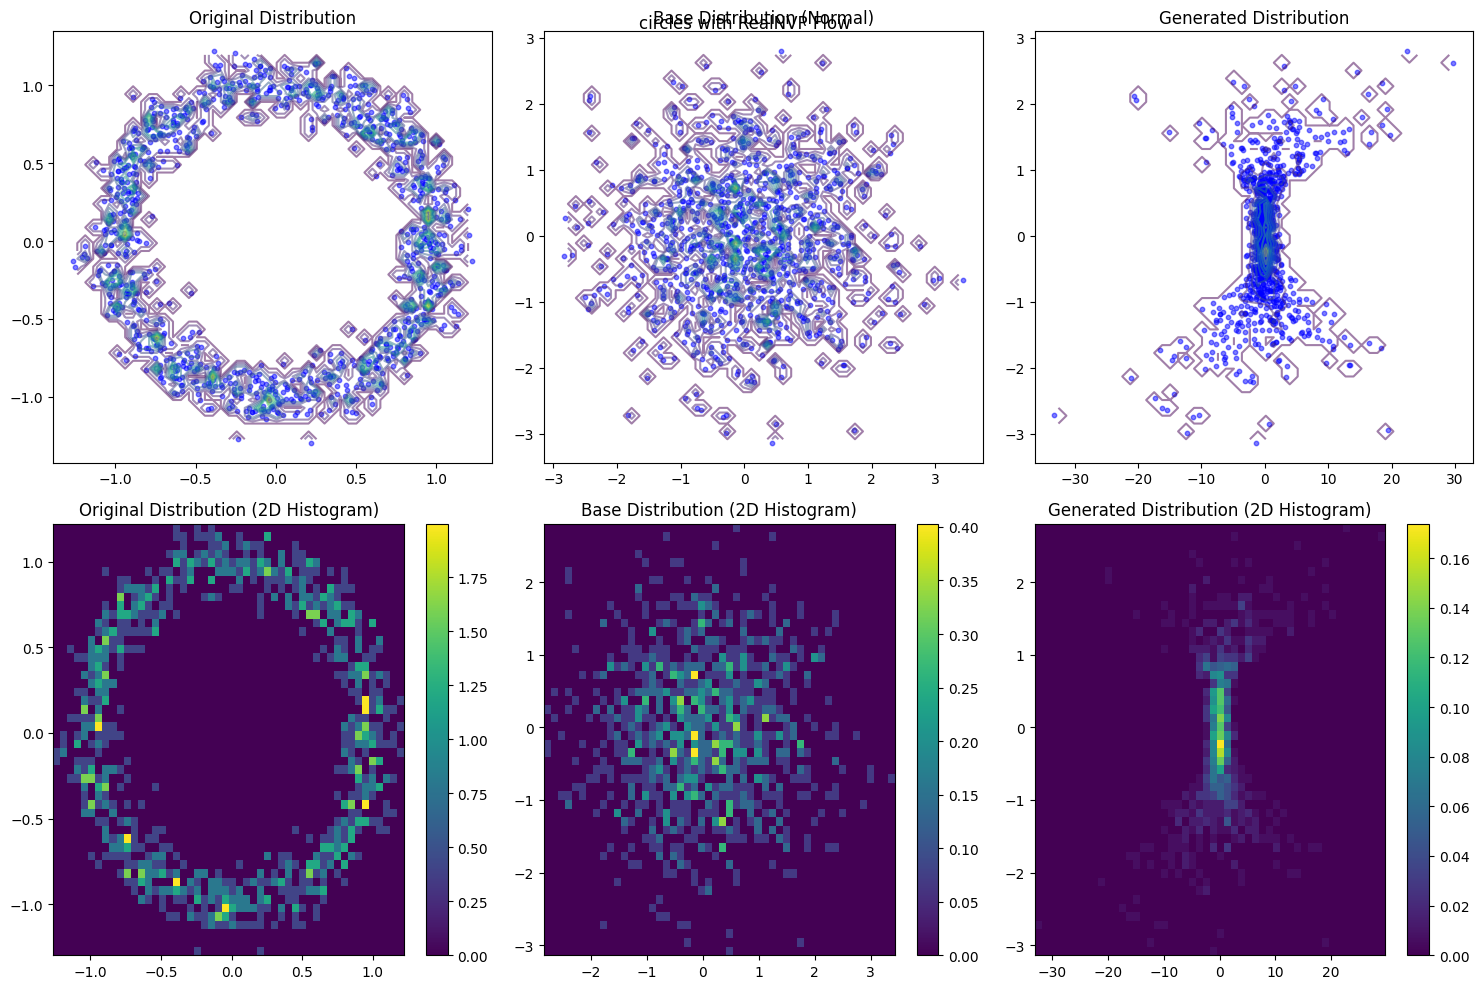

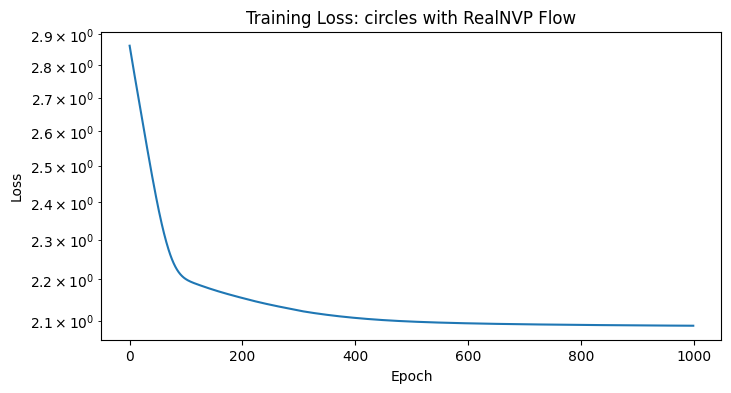


Training MAF architecture...
Epoch 100/1000, Loss: 2.0862
Epoch 200/1000, Loss: 1.9686
Epoch 300/1000, Loss: 1.9403
Epoch 400/1000, Loss: 1.9247
Epoch 500/1000, Loss: 1.9117
Epoch 600/1000, Loss: 1.8998
Epoch 700/1000, Loss: 1.8885
Epoch 800/1000, Loss: 1.8778
Epoch 900/1000, Loss: 1.8676
Epoch 1000/1000, Loss: 1.8579


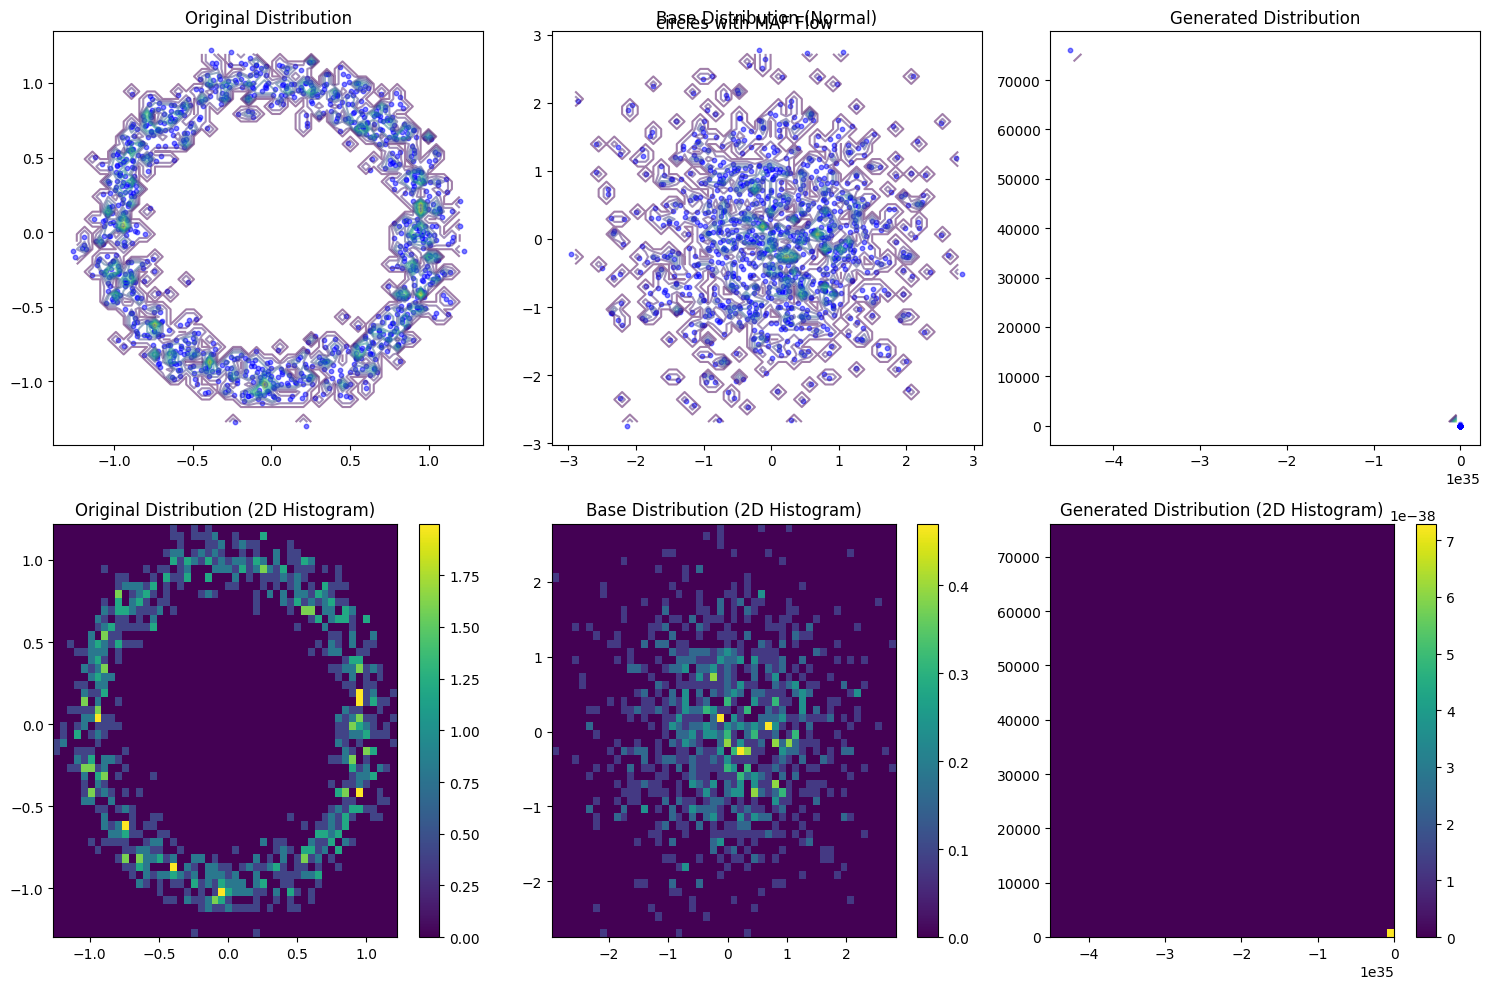

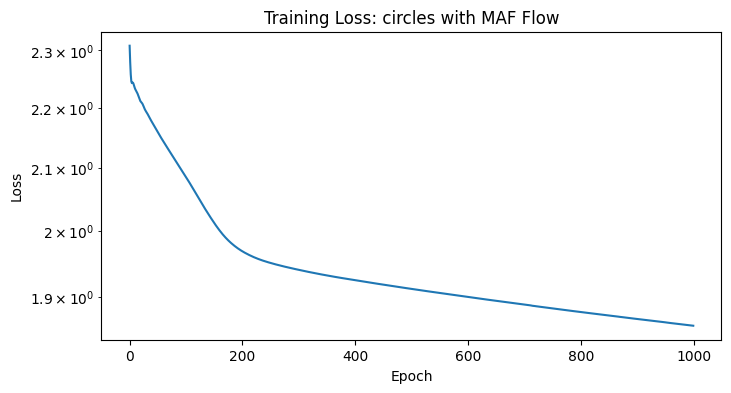


Training Mixed architecture...
Epoch 100/1000, Loss: 1.8221
Epoch 200/1000, Loss: 1.4758
Epoch 300/1000, Loss: 1.2738


In [ ]:
def main():
    # Generate toy datasets
    datasets = {
        'two_gaussians': create_toy_dataset(1000, 'two_gaussians'),
        'circles': create_toy_dataset(1000, 'circles'),
        'moons': create_toy_dataset(1000, 'moons')
    }
    
    # Create different flow models
    dim = 2
    flow_architectures = {
        'Simple': [
            PlanarFlow(dim),
            RadialFlow(dim),
            PlanarFlow(dim)
        ],
        'RealNVP': [
            RealNVPCoupling(dim),
            RealNVPCoupling(dim, mask_type='alternate'),
            RealNVPCoupling(dim, mask_type='half')
        ],
        'MAF': [
            MAF(dim),
            MAF(dim),
            MAF(dim)
        ],
        'Mixed': [
            PlanarFlow(dim),
            RealNVPCoupling(dim),
            MAF(dim)
        ]
    }
    
    # Train and visualize each combination
    for dataset_name, data in datasets.items():
        print(f"\nTraining on {dataset_name} dataset:")
        for arch_name, flows in flow_architectures.items():
            print(f"\nTraining {arch_name} architecture...")
            
            # Initialize flow model
            flow_model = NormalizingFlow(flows)
            
            # Train with lower learning rate for stability
            trained_flow, losses = train_flow(flow_model, data, n_epochs=1000, lr=1e-4)
            
            # Visualize
            fig = visualize_flow(trained_flow, data)
            plt.suptitle(f'{dataset_name} with {arch_name} Flow')
            plt.show()
            
            # Plot loss curve
            plt.figure(figsize=(8, 4))
            plt.plot(losses)
            plt.title(f'Training Loss: {dataset_name} with {arch_name} Flow')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.yscale('log')
            plt.show()

if __name__ == "__main__":
    main()